<a href="https://colab.research.google.com/github/tanyaoley/colab/blob/master/03_clustering.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 3. Рекомендательная система (20 баллов)

1. Скачайте этот ноутбук к себе.
2. Заполните пропущенные ячейки, отвечая на заданные вопросы. Там должен быть код! (если не сказано обратное)
3. Сохраните результат в своём гитхаб репозитории.

### Полезная литература

- [Лекция 8. Рекомендательный системы](https://www.youtube.com/watch?v=Te_6TqEhyTI&t=4s).
- [Туториал по рекомендательным системам](http://nbviewer.jupyter.org/urls/gitlab.7bits.it/isiganov/ml-course/raw/master/week05/theory/05-01-clustering.ipynb?inline=false)

- [ODS: Обучение без учителя: PCA и кластеризация](https://habrahabr.ru/company/ods/blog/325654/)
- [Интересные алгоритмы кластеризации, часть первая: Affinity propagation](https://habrahabr.ru/post/321216/) и другие статьи цикла
- [Глава 7: кластеризация и визуализация. К. В. Воронцов](http://www.machinelearning.ru/wiki/images/6/6d/Voron-ML-1.pdf)
- [Документация sklearn.clustering](http://scikit-learn.org/stable/modules/clustering.html)
- [K-Means Clustering - The Math of Intelligence. Siraj Raval](https://www.youtube.com/watch?v=9991JlKnFmk) объяснение с программированием KMeans вручную

В этой практике мы попробуем построить очень простую рекомендательную систему, основанную на поиске кластера похожих пользователей.  
Похожие они в том плане, что смотрят одинаковые фильмы и оценивают их приблизительно одинаково.  
Мы будем строить очень простую модель, по сути которая даже не является именно системой рекомендации, но как минимум она может быть первым шагом к ее построению: мы найдем класет похожих пользователей, узнаем какие фильмы они смотрят и одинаково любят, какие жанры предпочитают.

Лабораторная будет больше похожа на манипулции с одним большим датафреймом. Если у вас появятся интересные идеи, то можете попробовать их тоже. 

## Анализ отзывов аниме

Возьмем датасет с рейтингами аниме: https://www.kaggle.com/CooperUnion/anime-recommendations-database  
Кстати, вы можете посмотреть kernels - это jupyter notebooks, в которых другие люди тоже делали что-то с этим датасетом.

```
Anime.csv

anime_id - myanimelist.net's unique id identifying an anime.
name - full name of anime.
genre - comma separated list of genres for this anime.
type - movie, TV, OVA, etc.
episodes - how many episodes in this show. (1 if movie).
rating - average rating out of 10 for this anime.
members - number of community members that are in this anime's "group".


Rating.csv

user_id - non identifiable randomly generated user id.
anime_id - the anime that this user has rated.
rating - rating out of 10 this user has assigned (-1 if the user watched it but didn't assign a rating).
```

In [0]:
import pandas as pd

In [1]:
colab = True
if colab:
    from google.colab import drive
    drive.mount('/content/drive/')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive/


In [3]:
if colab:
    anime = pd.read_csv('/content/drive/My Drive/Data/anime/anime.csv.zip', index_col='anime_id')
else:
    anime = pd.read_csv('../../data/anime/anime.csv.zip', index_col='anime_id')
anime.dropna(inplace=True)
print(anime.shape)
anime.head()

(12017, 6)


,name,genre,type,episodes,rating,members
anime_id,,,,,,
32281,Kimi no Na wa.,"Drama, Romance, School, Supernatural",Movie,1,9.37,200630
5114,Fullmetal Alchemist: Brotherhood,"Action, Adventure, Drama, Fantasy, Magic, Mili...",TV,64,9.26,793665
28977,Gintama°,"Action, Comedy, Historical, Parody, Samurai, S...",TV,51,9.25,114262
9253,Steins;Gate,"Sci-Fi, Thriller",TV,24,9.17,673572
9969,Gintama&#039;,"Action, Comedy, Historical, Parody, Samurai, S...",TV,51,9.16,151266


In [4]:
if colab:
    ratings = pd.read_csv('/content/drive/My Drive/Data/anime/rating.csv.zip')
else:
    ratings = pd.read_csv('../../data/anime/rating.csv.zip')
print(ratings.shape)
ratings.head()

(7813737, 3)


,user_id,anime_id,rating
0,1,20,-1
1,1,24,-1
2,1,79,-1
3,1,226,-1
4,1,241,-1


## Обзор данных (1 балл)

Постройте графики для обзора признаков: anime.type, episodes, rating, members.

Посмотрите на info по таблицам, нам важно знать сколько оперативной памяти занимает каждая таблица, так как дальше у нас будет декартово произведение таблиц и размер может вылететь за 5 гигабайт.

672952
187529816


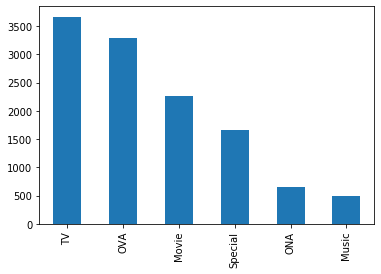

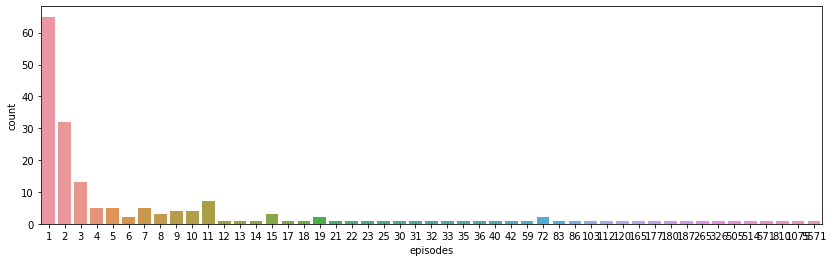

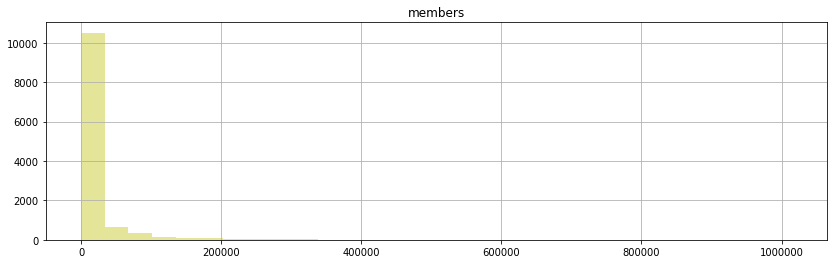

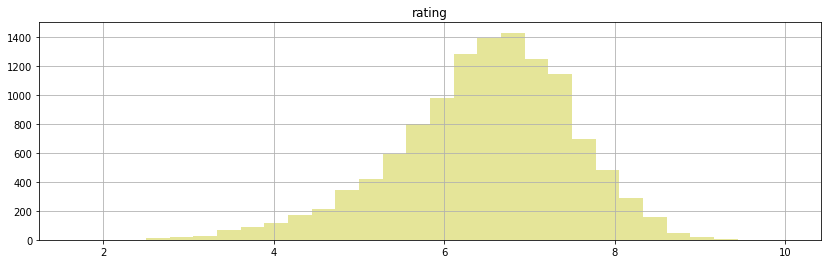

In [5]:
import matplotlib.pyplot as plt
import seaborn as sns

fig,ax = plt.subplots(1,1, figsize=(6,4), sharex=True)
plt.sca(ax)
anime['type'].value_counts().plot(kind='bar') 
fig,ax = plt.subplots(1,1, figsize=(14,4), sharex=True)
plt.sca(ax)
sns.countplot(anime['episodes'].value_counts())

fig,ax = plt.subplots(1,1, figsize=(14,4), sharex=True)
plt.sca(ax)
anime['members'].hist(bins=30,color='y',alpha=0.4)
plt.title('members')


fig,ax = plt.subplots(1,1, figsize=(14,4), sharex=True)
plt.sca(ax)
anime['rating'].hist(bins=30,color='y',alpha=0.4)
plt.title('rating')

print(anime.memory_usage(index=True).sum())
print(ratings.memory_usage(index=True).sum())

## Жанры (4 балла)

Как в материалах к воркшопу постройте таблицу, в которой в строках будет названиефильма, а в столбцах жанр. В ячейках 1 - если в этого фильма есть такой жанр и 0 иначе.

Постройте countplot для визуализации количества фильмов каждого из жанров.

Постройте график, на котором будут изображениы распределения рейтингов по каждому из жанров. Должно получиться что-то подобное: ![Imgur](https://i.imgur.com/hyuA6ia.png)


In [6]:
from itertools import chain
def flatmap(f, items):
    return chain.from_iterable(map(f, items))

def genre_splitter(genre_names):
    return genre_names.split(", ")
    
m_uniq = anime['genre'].unique() 
genres = list(set(flatmap(genre_splitter, m_uniq))) 
anime_genres = pd.DataFrame(index=anime.index)
for g in genres:
    anime_genres[g] = anime['genre'].str.contains(g).astype(int)

anime_genres = anime_genres.join(anime['name'], on = 'anime_id').set_index('name')
anime_genres


,Cars,Vampire,Historical,Martial Arts,Super Power,Thriller,Shoujo,Horror,Psychological,Kids,Fantasy,Shoujo Ai,Mystery,Harem,Police,Sci-Fi,Space,Mecha,Yaoi,Slice of Life,Music,Seinen,Josei,Game,Hentai,Shounen Ai,Romance,Yuri,Magic,Parody,Drama,Action,Samurai,Comedy,Adventure,Shounen,Dementia,Supernatural,School,Demons,Ecchi,Military,Sports
name,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
Kimi no Na wa.,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,1,1,0,0,0,0
Fullmetal Alchemist: Brotherhood,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,1,0,0,1,1,0,0,0,0,0,1,0
Gintama°,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,1,1,0,1,0,0,0,0,0,0,0
Steins;Gate,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
Gintama&#039;,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,1,1,0,1,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Toushindai My Lover: Minami tai Mecha-Minami,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
Under World,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
Violence Gekiga David no Hoshi,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


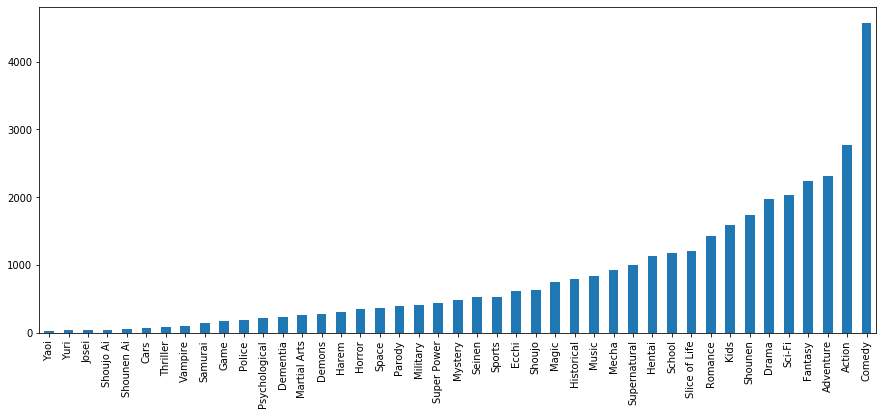

In [7]:
plt.figure(figsize=(15,6))
anime_genres.sum().sort_values().plot(kind = 'bar')

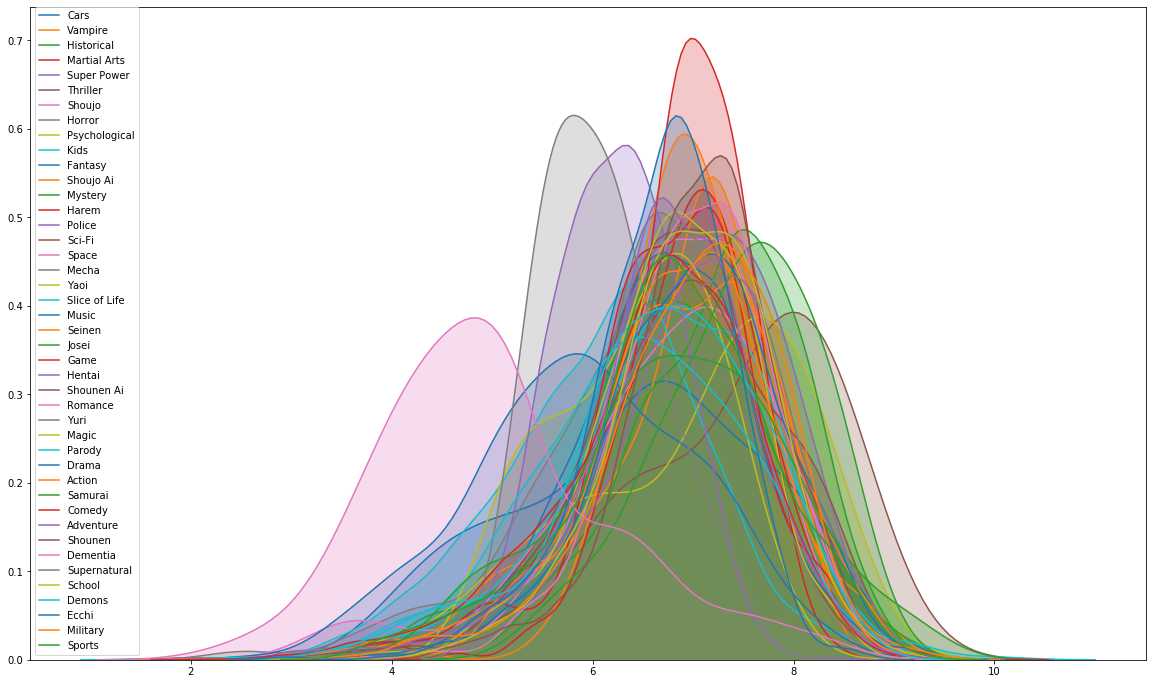

In [8]:
import matplotlib.pyplot as plt
import seaborn as sns
plt.figure(figsize=(20,12))

for g in genres: 
  sns.kdeplot(anime[anime['genre'].str.contains(g)]['rating'], shade = True, label = g)
 


## Рейтинг (1 балл)

Постройте график, показывающий сколько оценок каждого рейтинга поставили пользователи из таблицы `ratings`.

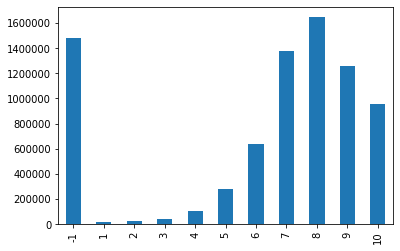

In [9]:
_ =ratings['rating'].value_counts().sort_index().plot(kind='bar')

## Фильтрация данных (5 баллов)

Если мы сразу же построим кросстаб матрицу `anime` vs `user`, где в ячейках рейтинг, который поставил юзер этому фильму, то у нас это все займет около 6 гигабайт памяти. Можно значительно сократить размер матрицы, если выкинуть данные об аниме, которое почти никто не оценил и юзеров, которые почти ничего не оценивали.

Для этого постройте два новых датафрейма:

- anime_watches, где индексом является anime_name, а значением - количество его обзоров
- user_ratings, где индексом является user_id, а значением - количество вниме, которое он оценил.

Далее, соедините (join) 4 таблицы: ratings, anime, anime_watches, user_ratings и назовите новую таблицу anime_ratings.

Что означает `-1` в таблице рейтинга? Замените все -1 на средний рейтинг аниме.

Удалите из таблицы все те значения, у которых количество обзоров и рейтингов меньше медианного значения. То есть мы удалим половину аниме и половину юзеров.

In [10]:
import numpy as np
user_ratings = pd.DataFrame(ratings[ratings['rating']!= -1]['user_id'].value_counts(),index = ratings['user_id'].unique())

user_ratings.columns = ['u_raiting_anime_count']
user_ratings.index.names = ['user_id']
user_ratings

,u_raiting_anime_count
user_id,
1,4.0
2,1.0
3,92.0
4,NaN
5,459.0
...,...
73512,12.0
73513,33.0
73514,1.0


In [11]:
tmp = pd.DataFrame(ratings[ratings['rating']!= -1]['anime_id'].value_counts(),anime.index)
tmp.columns = ['review_count']
anime_watches = pd.merge(tmp,anime, on =[tmp.index,'anime_id'])[['review_count','name']].set_index('name')
anime_watches

,review_count
name,
Kimi no Na wa.,1961.0
Fullmetal Alchemist: Brotherhood,21494.0
Gintama°,1188.0
Steins;Gate,17151.0
Gintama&#039;,3115.0
...,...
Toushindai My Lover: Minami tai Mecha-Minami,2.0
Under World,2.0
Violence Gekiga David no Hoshi,1.0


In [12]:
anime_ratings = ratings.join(user_ratings, on = "user_id").join(anime, on = "anime_id", lsuffix="_user", rsuffix="_average").join(anime_watches, on = "name") 
anime_ratings.fillna(0)
# -1 в таблице рейтинга - пользователь посмотрел аниме,но не оценил
anime_ratings['rating_user'] = np.where(anime_ratings['rating_user'] == -1, anime_ratings['rating_average'], anime_ratings['rating_user'])

review_median = anime_watches['review_count'].median()
rating_median = user_ratings['u_raiting_anime_count'].median()


anime_ratings= anime_ratings[anime_ratings.review_count > review_median] 
anime_ratings= anime_ratings[anime_ratings.u_raiting_anime_count > rating_median]



anime_ratings

,user_id,anime_id,rating_user,u_raiting_anime_count,name,genre,type,episodes,rating_average,members,review_count
156,3,20,8.0,92.0,Naruto,"Action, Comedy, Martial Arts, Shounen, Super P...",TV,220,7.81,683297.0,22071.0
157,3,154,6.0,92.0,Shaman King,"Action, Adventure, Comedy, Drama, Shounen, Sup...",TV,64,7.83,169517.0,6336.0
158,3,170,9.0,92.0,Slam Dunk,"Comedy, Drama, School, Shounen, Sports",TV,101,8.56,82570.0,2281.0
159,3,199,10.0,92.0,Sen to Chihiro no Kamikakushi,"Adventure, Drama, Supernatural",Movie,1,8.93,466254.0,19481.0
160,3,225,9.0,92.0,Dragon Ball GT,"Action, Adventure, Comedy, Fantasy, Magic, Sci...",TV,64,6.72,226625.0,9124.0
...,...,...,...,...,...,...,...,...,...,...,...
7813730,73515,13659,8.0,179.0,Ore no Imouto ga Konnani Kawaii Wake ga Nai.,"Comedy, Seinen, Slice of Life",TV,13,7.43,194791.0,6883.0
7813731,73515,14345,7.0,179.0,Btooom!,"Action, Psychological, Sci-Fi, Seinen",TV,12,7.68,329561.0,10223.0
7813732,73515,16512,7.0,179.0,Devil Survivor 2 The Animation,"Action, Demons, Supernatural",TV,13,7.06,101266.0,2836.0
7813733,73515,17187,9.0,179.0,Ghost in the Shell: Arise - Border:1 Ghost Pain,"Mecha, Police, Psychological, Sci-Fi",Movie,1,7.64,31747.0,934.0


## Матрица user-item (3 балла)

Превратите таблицу anime_ratings в матрицу, где в строках user_id, в стобцах anime_name, а в ячейках рейтинг. Посмотрите сколько занимет в памяти эта матрица.

In [13]:

anime_ratings = anime_ratings.drop(['genre','type', 'episodes', 'rating_average', 'members', 'review_count','u_raiting_anime_count'],1)
anime_ratings.set_index('user_id')
anime_ratings = pd.pivot_table(anime_ratings, values = 'rating_user', index=['user_id'],
              columns=['name'], aggfunc=np.sum)

anime_ratings.fillna(0,inplace=True)

print(anime_ratings.memory_usage(index=True).sum())
anime_ratings

1362765328


name,&quot;Bungaku Shoujo&quot; Kyou no Oyatsu: Hatsukoi,&quot;Bungaku Shoujo&quot; Memoire,&quot;Bungaku Shoujo&quot; Movie,.hack//G.U. Returner,.hack//G.U. Trilogy,.hack//G.U. Trilogy: Parody Mode,.hack//Gift,.hack//Intermezzo,.hack//Liminality,.hack//Quantum,.hack//Quantum: Sore ike! Bokura no Chimuchimu-chan!!,.hack//Roots,.hack//Sign,.hack//Tasogare no Udewa Densetsu,.hack//Tasogare no Udewa Densetsu: Offline de Aimashou,.hack//The Movie: Sekai no Mukou ni,.hack//Unison,.hack//Versus: The Thanatos Report,009 Re:Cyborg,009-1,009-1: R&amp;B,07-Ghost,1+2=Paradise,1001 Nights,11-nin Iru!,11eyes,11eyes: Momoiro Genmutan,12-sai.,12-sai.: Chicchana Mune no Tokimeki,15 Bishoujo Hyouryuuki,21-ji no Onna: Newscaster Katsuragi Miki,30-sai no Hoken Taiiku,30-sai no Hoken Taiiku Specials,30th Gundam Perfect Mission,3x3 Eyes,3x3 Eyes Seima Densetsu,4-Day Weekend,91 Days,91 Days Recap,A Kite,...,Zetsuai 1989,Zetsuen no Tempest,Zetsumetsu Kigu Shoujo: Amazing Twins,Zettai Bouei Leviathan,Zettai Junpaku♡Mahou Shoujo,Zettai Junshu☆Kyousei Kozukuri Kyokashou!!,Zettai Karen Children,Zettai Karen Children OVA: Aitazousei! Ubawareta Mirai?,Zettai Karen Children: The Unlimited - Hyoubu Kyousuke,Zettai Shougeki: Platonic Heart,Zettai Shounen,Zipang,Zoids,Zoids Fuzors,Zoids Genesis,Zoids Shinseiki/Zero,Zoku Natsume Yuujinchou,Zoku Sayonara Zetsubou Sensei,Zombie-Loan,Zombie-Loan Specials,"Zone of the Enders: Dolores, I",Zone of the Enders: Idolo,Zutto Mae kara Suki deshita.: Kokuhaku Jikkou Iinkai,_Summer,_Summer Specials,eX-Driver,eX-Driver the Movie,eX-Driver: Nina &amp; Rei Danger Zone,ef: A Tale of Melodies.,ef: A Tale of Melodies. - Prologue,ef: A Tale of Memories.,ef: A Tale of Memories. - Prologue,ef: A Tale of Memories. - Recollections,iDOLM@STER Xenoglossia,s.CRY.ed,xxxHOLiC,xxxHOLiC Kei,xxxHOLiC Movie: Manatsu no Yoru no Yume,xxxHOLiC Rou,xxxHOLiC Shunmuki
user_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,8.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,7.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,7.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0
7,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
11,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
14,0.0,0.0,8.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,6.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
73503,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.

## Понижение размерности (1 балл)

kNN будет плохо работать на многомерных данных, поэтому надо понизить размерности матрицы с помощью алгоритма PCA. Количество размерностей установите от 4 до 10 - как вам покажется оптимальнее. (можете это исправить когда запустите kNN и получите результаты).

In [14]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

pca = PCA(n_components=8, random_state=42)
%time df_pca = pca.fit_transform(anime_ratings)

ps = pd.DataFrame(df_pca)


CPU times: user 17.7 s, sys: 2.52 s, total: 20.2 s
Wall time: 11.2 s


## Обучение kMeans (1 балл)

Обучим kMeans, чтобы он нашел нам центры кластеров нашей выборки.

Так как в строках у нас user_id, то центры класетров - это будут характеристики пользователей в терминах их оценок аниме. Используя эту информацию мы можем вычислить список характерных аниме для конкретного кластера.

- обучите kMeans
- создайте копию матрицы и добавьте новую колонку - кластер. Положите в нее результат предсказания кластера для каждого пользователя. (метод predict)
- нарисуйте cout plot количества юзеров в каждом кластере. Если получается сильно неравномерное распределение, то вам надо подобрать другое количество кластеров или изменить размерность в предыдущем шаге.

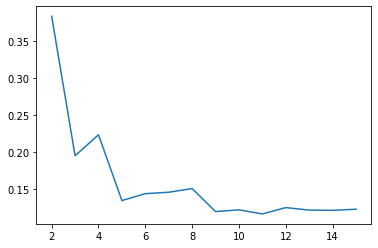

In [15]:
from sklearn.metrics import silhouette_score, silhouette_samples
from sklearn.cluster import KMeans

def draw_sil_score(X, range_n_clusters=[2, 3, 4, 5, 6, 10, 12, 13, 20]):
    scores = []
    for n_clusters in range_n_clusters:
        clusterer = KMeans(n_clusters=n_clusters, random_state=10)
        cluster_labels = clusterer.fit_predict(X)
        silhouette_avg = silhouette_score(X, cluster_labels)
        scores.append(silhouette_avg)
    plt.plot(range_n_clusters, scores)
    return range_n_clusters[np.argmax(scores)]
cluster = draw_sil_score(ps,range(2,16))

AxesSubplot(0.125,0.125;0.775x0.755)


name,&quot;Bungaku Shoujo&quot; Kyou no Oyatsu: Hatsukoi,&quot;Bungaku Shoujo&quot; Memoire,&quot;Bungaku Shoujo&quot; Movie,.hack//G.U. Returner,.hack//G.U. Trilogy,.hack//G.U. Trilogy: Parody Mode,.hack//Gift,.hack//Intermezzo,.hack//Liminality,.hack//Quantum,.hack//Quantum: Sore ike! Bokura no Chimuchimu-chan!!,.hack//Roots,.hack//Sign,.hack//Tasogare no Udewa Densetsu,.hack//Tasogare no Udewa Densetsu: Offline de Aimashou,.hack//The Movie: Sekai no Mukou ni,.hack//Unison,.hack//Versus: The Thanatos Report,009 Re:Cyborg,009-1,009-1: R&amp;B,07-Ghost,1+2=Paradise,1001 Nights,11-nin Iru!,11eyes,11eyes: Momoiro Genmutan,12-sai.,12-sai.: Chicchana Mune no Tokimeki,15 Bishoujo Hyouryuuki,21-ji no Onna: Newscaster Katsuragi Miki,30-sai no Hoken Taiiku,30-sai no Hoken Taiiku Specials,30th Gundam Perfect Mission,3x3 Eyes,3x3 Eyes Seima Densetsu,4-Day Weekend,91 Days,91 Days Recap,A Kite,...,Zetsuen no Tempest,Zetsumetsu Kigu Shoujo: Amazing Twins,Zettai Bouei Leviathan,Zettai Junpaku♡Mahou Shoujo,Zettai Junshu☆Kyousei Kozukuri Kyokashou!!,Zettai Karen Children,Zettai Karen Children OVA: Aitazousei! Ubawareta Mirai?,Zettai Karen Children: The Unlimited - Hyoubu Kyousuke,Zettai Shougeki: Platonic Heart,Zettai Shounen,Zipang,Zoids,Zoids Fuzors,Zoids Genesis,Zoids Shinseiki/Zero,Zoku Natsume Yuujinchou,Zoku Sayonara Zetsubou Sensei,Zombie-Loan,Zombie-Loan Specials,"Zone of the Enders: Dolores, I",Zone of the Enders: Idolo,Zutto Mae kara Suki deshita.: Kokuhaku Jikkou Iinkai,_Summer,_Summer Specials,eX-Driver,eX-Driver the Movie,eX-Driver: Nina &amp; Rei Danger Zone,ef: A Tale of Melodies.,ef: A Tale of Melodies. - Prologue,ef: A Tale of Memories.,ef: A Tale of Memories. - Prologue,ef: A Tale of Memories. - Recollections,iDOLM@STER Xenoglossia,s.CRY.ed,xxxHOLiC,xxxHOLiC Kei,xxxHOLiC Movie: Manatsu no Yoru no Yume,xxxHOLiC Rou,xxxHOLiC Shunmuki,predict
user_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,8.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,7.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,7.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,2
7,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2
11,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
14,0.0,0.0,8.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,6.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
73503,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0

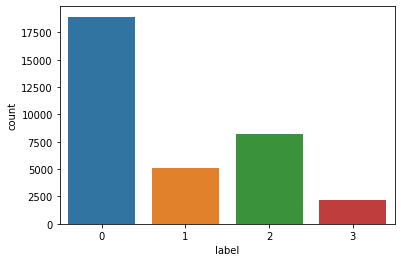

In [17]:
cluster = 4
clf = KMeans(n_clusters=cluster)

clf.fit(ps)

import seaborn as sns
copy = anime_ratings

prediction = clf.predict(ps)

copy['predict'] =pd.Series(prediction, index = copy.index)
df = pd.DataFrame(clf.labels_, index = anime_ratings.index)
df.columns = ['label'] 

print(sns.countplot(x =df['label'] , data  = df ))
copy

## Top 15 аниме (2 балла)

Найдем Top-15 аниме для каждого кластера. Для этого:

- найдите средний рейтинг аниме в каждом кластере. 
- для каждого кластера возьмите набор аниме с их средним рейтингом, отсортируйте этот набор по убыванию рейтинга. 
- возьмите первые 15 элементов из набора - это и будет топ15 аниме в кластере.
- согласны ли вы с содержимым кластера?

In [18]:
for i in range(cluster):
  print("mean rating in cluster{0}: {1}".format(i,copy[copy['predict']==i].drop('predict',axis=1).mean().mean()))

for i in range(cluster):
  print("top 15 in cluster {0}: \n{1}".format(i,copy[copy['predict']==i].drop('predict',axis=1).mean().sort_values(ascending = False).iloc[0:15]))
  print("_______________________________")



mean rating in cluster0: 0.14896721128857818
mean rating in cluster1: 0.43028141784391283
mean rating in cluster2: 0.320658825303331
mean rating in cluster3: 0.9251147395960968
top 15 in cluster 0: 
name
Death Note                            5.640129
Code Geass: Hangyaku no Lelouch       3.967577
Shingeki no Kyojin                    3.967283
Sen to Chihiro no Kamikakushi         3.923716
Elfen Lied                            3.652505
Fullmetal Alchemist                   3.607308
Fullmetal Alchemist: Brotherhood      3.601523
Sword Art Online                      3.577403
Code Geass: Hangyaku no Lelouch R2    3.440698
Angel Beats!                          3.411317
Naruto                                3.259467
Toradora!                             3.124599
Howl no Ugoku Shiro                   2.978946
Ouran Koukou Host Club                2.822577
Clannad                               2.779464
dtype: float64
_______________________________
top 15 in cluster 1: 
name
Code Geass: Hangy

## Top 5 жанров (2 балла)

Если соеднить таблицу с аниме с таблицей жанров, то можно найти топ жанров для каждого кластера. Придумайте сами как это сделать, так как тут много способов:

- найти средний рейтинг для аниме каждого жанра
- посчитать сколько представителей каждого жанра есть среди top100 аниме кластера (кстати работает лучше)
- ???

In [22]:
import operator
anime_copy = anime[['name','genre']]
for i in range(cluster):
  dfc = pd.DataFrame(copy[copy['predict']==i].drop('predict',axis=1).mean().sort_values(ascending = False).iloc[0:100])
  dfc = dfc.merge(anime_copy,left_on=dfc.index,right_on='name')
  d = dict()
  for g in genres:
    d[g] = (dfc['genre'].str.contains(g).astype(int).sum())
  sorted_d = sorted(d.items(), key=operator.itemgetter(1),reverse=True)
  print("top 10 in cluster {0} {1}".format(i,sorted_d[0:10]))
    


top 10 in cluster 0 [('Action', 55), ('Comedy', 50), ('Supernatural', 34), ('Fantasy', 33), ('Drama', 32), ('Romance', 31), ('Adventure', 28), ('Sci-Fi', 26), ('Shounen', 23), ('School', 21)]
top 10 in cluster 1 [('Action', 53), ('Comedy', 39), ('Romance', 36), ('Drama', 33), ('Supernatural', 32), ('Sci-Fi', 28), ('Fantasy', 25), ('Adventure', 25), ('School', 22), ('Mystery', 19)]
top 10 in cluster 2 [('Action', 54), ('Comedy', 43), ('Supernatural', 38), ('Romance', 31), ('School', 31), ('Fantasy', 26), ('Shounen', 26), ('Drama', 25), ('Adventure', 21), ('Sci-Fi', 19)]
top 10 in cluster 3 [('Comedy', 54), ('Action', 48), ('Romance', 47), ('School', 41), ('Supernatural', 38), ('Fantasy', 28), ('Sci-Fi', 23), ('Harem', 21), ('Drama', 21), ('Shounen', 20)]
